## Implementation of graph-based semi-supervised learning
* Similar implementation of graph-based SSL can be found at scikit-learn (sklearn.semi_supervised.LabelPropagation)
* To protect patient's private information, we can not share the data. (To reqeust data access, please contact author: Seung Mi Lee. M.D., Ph.D.)

In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.neighbors import kneighbors_graph
from sklearn import datasets

### Load toy dataset: breast cancer wisconsin dataset
* y == 1 (pos): WDBC-Benign
* y ==0 (neg): WDBC-Malignant

In [2]:
X, y = datasets.load_breast_cancer(return_X_y = True)

from sklearn.preprocessing import StandardScaler
Scaler = StandardScaler()
X = StandardScaler().fit_transform(X) # centering

pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,...,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,...,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,...,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,...,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,...,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,2.110995,0.721473,2.060786,2.343856,1.041842,0.219060,1.947285,2.320965,-0.312589,-0.931027,...,1.901185,0.117700,1.752563,2.015301,0.378365,-0.273318,0.664512,1.629151,-1.360158,-0.709091
565,1.704854,2.085134,1.615931,1.723842,0.102458,-0.017833,0.693043,1.263669,-0.217664,-1.058611,...,1.536720,2.047399,1.421940,1.494959,-0.691230,-0.394820,0.236573,0.733827,-0.531855,-0.973978
566,0.702284,2.045574,0.672676,0.577953,-0.840484,-0.038680,0.046588,0.105777,-0.809117,-0.895587,...,0.561361,1.374854,0.579001,0.427906,-0.809587,0.350735,0.326767,0.414069,-1.104549,-0.318409
567,1.838341,2.336457,1.982524,1.735218,1.525767,3.272144,3.296944,2.658866,2.137194,1.043695,...,1.961239,2.237926,2.303601,1.653171,1.430427,3.904848,3.197605,2.289985,1.919083,2.219635


* checking class index (pos / neg)

In [3]:
# class index
idx_pos = np.where(y==1)[0]
idx_neg = np.where(y==0)[0]

print("number of positive samples: ", len(idx_pos))
print("number of negative samples: ", len(idx_neg))

number of positive samples:  357
number of negative samples:  212


### Calculating Distance matrix
* Dist: distance matrix
* For toy example, we used euclidean distances to measure proximity between samples
* Any distance matrix is allowed
* If we can obtain similarity (weight) matrix directly (such as cosine similarity), can skip this section.

In [4]:
Dist = metrics.pairwise.euclidean_distances(X, X) # Pairwise Eucliden distance between samples

In [5]:
print("Distance Matrix")
pd.DataFrame(Dist)

Distance Matrix


,0,1,2,3,4,5,6,7,8,9,...,559,560,561,562,563,564,565,566,567,568
0,0.000000,10.318497,6.777634,10.472674,8.671036,8.409626,9.851947,8.937339,8.467881,11.192901,...,13.607706,12.558461,18.080384,9.754661,6.352470,9.361612,11.151798,11.828483,6.975651,16.463850
1,10.318497,0.000000,5.032015,16.250739,4.378888,8.643779,2.536028,7.062008,8.753325,14.202698,...,8.736355,6.475704,11.326509,10.598271,7.984678,6.256050,5.443128,4.984232,10.898643,10.188130
2,6.777634,5.032015,0.000000,12.844721,4.462229,6.891109,4.435317,6.003183,6.307564,11.667139,...,9.427044,7.449524,13.494418,7.947333,4.382949,5.129482,5.724352,6.152974,6.927286,12.354363
3,10.472674,16.250739,12.844721,0.000000,15.375300,9.371169,15.032654,11.335594,9.337818,8.479500,...,15.396673,15.054719,20.209563,10.324999,13.394912,16.744109,16.476531,15.831880,11.100113,18.138345
4,8.671036,4.378888,4.462229,15.375300,0.000000,8.242866,4.924715,6.946067,8.693604,13.909836,...,9.145804,7.409713,12.694056,10.722591,6.304296,4.351815,6.322558,6.311797,10.108551,11.700253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,9.361612,6.256050,5.129482,16.744109,4.351815,10.522517,6.679567,8.683591,10.330740,14.859648,...,10.536542,8.904967,13.695994,11.366176,5.134435,0.000000,5.389534,7.333393,9.499104,13.771702
565,11.151798,5.443128,5.724352,16.476531,6.322558,9.950762,5.191519,7.712302,9.169582,14.196756,...,7.474148,6.121907,9.710069,9.968054,7.116586,5.389534,0.000000,4.683274,9.672349,10.665585
566,11.828483,4.984232,6.152974,15.831880,6.311797,8.283295,4.175421,6.302524,7.886673,12.784653,...,5.455329,3.283422,8.686429,8.774320,8.340570,7.333393,4.683274,0.000000,10.551703,8.102413
567,6.975651,10.898643,6.927286,11.100113,10.108551,9.300743,9.885415,9.284418,8.092692,8.897570,...,12.487823,11.812630,17.104540,5.965558,5.564528,9.499104,9.672349,10.551703,0.000000,16.674633


### Calculating similarity matrix
* <b>Weight</b>: similarity (weight) matrix
* To transform distance matrix to similarity matrix, we used Radial basis function kernel (rbf Kernel)
* If the distance matrix have ranged on (0, 1), we can simply calculate simlarity matrix as <b> 1 - distance matrix </b>
* sigma is a scale parameter for rbf kernel.

In [6]:
sigma = 1 # scale parameter for gaussian kernel
Weight = np.exp(-Dist / sigma ** 2)  

In [7]:
pd.DataFrame(Weight)

,0,1,2,3,4,5,6,7,8,9,...,559,560,561,562,563,564,565,566,567,568
0,1.000000e+00,3.301670e-05,0.001139,2.829929e-05,1.714813e-04,0.000223,5.264461e-05,0.000131,0.000210,1.377161e-05,...,1.230972e-06,3.515036e-06,1.405365e-08,0.000058,1.742438e-03,8.596140e-05,1.434946e-05,7.293818e-06,9.343577e-04,7.076866e-08
1,3.301670e-05,1.000000e+00,0.006526,8.757775e-08,1.253929e-02,0.000176,7.918029e-02,0.000857,0.000158,6.789640e-07,...,1.606384e-04,1.540414e-03,1.204924e-05,0.000025,3.406423e-04,1.918809e-03,4.325931e-03,6.845035e-03,1.848330e-05,3.761417e-05
2,1.138967e-03,6.525646e-03,1.000000,2.640029e-06,1.153662e-02,0.001017,1.185131e-02,0.002471,0.001822,8.570890e-06,...,8.051684e-05,5.817187e-04,1.378633e-06,0.000354,1.248848e-02,5.919626e-03,3.265468e-03,2.127146e-03,9.806588e-04,4.310903e-06
3,2.829929e-05,8.757775e-08,0.000003,1.000000e+00,2.101803e-07,0.000085,2.960748e-07,0.000012,0.000088,2.076825e-04,...,2.057359e-07,2.896134e-07,1.671469e-09,0.000033,1.522873e-06,5.347191e-08,6.987686e-08,1.331380e-07,1.511061e-05,1.326224e-08
4,1.714813e-04,1.253929e-02,0.011537,2.101803e-07,1.000000e+00,0.000263,7.264794e-03,0.000962,0.000168,9.099868e-07,...,1.066664e-04,6.053446e-04,3.069315e-06,0.000022,1.828434e-03,1.288341e-02,1.795344e-03,1.814769e-03,4.072978e-05,8.291720e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,8.596140e-05,1.918809e-03,0.005920,5.347191e-08,1.288341e-02,0.000027,1.256322e-03,0.000169,0.000033,3.519951e-07,...,2.654837e-05,1.357131e-04,1.126952e-06,0.000012,5.890381e-03,1.000000e+00,4.564099e-03,6.533529e-04,7.491890e-05,1.044782e-06
565,1.434946e-05,4.325931e-03,0.003265,6.987686e-08,1.795344e-03,0.000048,5.563547e-03,0.000447,0.000104,6.830102e-07,...,5.675689e-04,2.194268e-03,6.066954e-05,0.000047,8.115329e-04,4.564099e-03,1.000000e+00,9.248686e-03,6.300166e-05,2.333433e-05
566,7.293818e-06,6.845035e-03,0.002127,1.331380e-07,1.814769e-03,0.000253,1.536872e-02,0.001832,0.000376,2.803469e-06,...,4.273472e-03,3.749973e-02,1.688619e-04,0.000155,2.386364e-04,6.533529e-04,9.248686e-03,1.000000e+00,2.614891e-05,3.028076e-04
567,9.343577e-04,1.848330e-05,0.000981,1.511061e-05,4.072978e-05,0.000091,5.091184e-05,0.000093,0.000306,1.367208e-04,...,3.772310e-06,7.410371e-06,3.729004e-08,0.002566,3.831387e-03,7.491890e-05,6.300166e-05,2.614891e-05,1.000000e+00,5.731905e-08


### [Optional] Convert fully connected graph to sparse graph (using k-NN)
* Calculating adjacency matrix for sparse graph (k-NN)
* <b>k</b>: hyperparameter for selecting number of nearest samples
* This parts generate adjacency matrix ('1' if they are connected, '0' otherwise)

In [8]:
Adj_k = kneighbors_graph(X, 20, mode='connectivity', metric='euclidean')  # X input matrix,  Connectivity: 20-Nearest neighbors
Adj_k = Adj_k.toarray() # convert adjacency list to adjancecy matrix

# Convert symmetric adj matrix: Function (kneighbors_graph) cannot guarantee symmetric matrix
Adj_k = np.triu(Adj_k) + np.tril(Adj_k) + np.triu(Adj_k).transpose()+np.tril(Adj_k).transpose()
Adj_k = np.where(Adj_k >= 1, 1, 0) # symmetric connectivty for k-NN

In [9]:
pd.DataFrame(Adj_k)

,0,1,2,3,4,5,6,7,8,9,...,559,560,561,562,563,564,565,566,567,568
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,1,0,0,1,1,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
565,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
566,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
567,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0


* Similarity matrix for dense graph

In [10]:
pd.DataFrame(Weight)

,0,1,2,3,4,5,6,7,8,9,...,559,560,561,562,563,564,565,566,567,568
0,1.000000e+00,3.301670e-05,0.001139,2.829929e-05,1.714813e-04,0.000223,5.264461e-05,0.000131,0.000210,1.377161e-05,...,1.230972e-06,3.515036e-06,1.405365e-08,0.000058,1.742438e-03,8.596140e-05,1.434946e-05,7.293818e-06,9.343577e-04,7.076866e-08
1,3.301670e-05,1.000000e+00,0.006526,8.757775e-08,1.253929e-02,0.000176,7.918029e-02,0.000857,0.000158,6.789640e-07,...,1.606384e-04,1.540414e-03,1.204924e-05,0.000025,3.406423e-04,1.918809e-03,4.325931e-03,6.845035e-03,1.848330e-05,3.761417e-05
2,1.138967e-03,6.525646e-03,1.000000,2.640029e-06,1.153662e-02,0.001017,1.185131e-02,0.002471,0.001822,8.570890e-06,...,8.051684e-05,5.817187e-04,1.378633e-06,0.000354,1.248848e-02,5.919626e-03,3.265468e-03,2.127146e-03,9.806588e-04,4.310903e-06
3,2.829929e-05,8.757775e-08,0.000003,1.000000e+00,2.101803e-07,0.000085,2.960748e-07,0.000012,0.000088,2.076825e-04,...,2.057359e-07,2.896134e-07,1.671469e-09,0.000033,1.522873e-06,5.347191e-08,6.987686e-08,1.331380e-07,1.511061e-05,1.326224e-08
4,1.714813e-04,1.253929e-02,0.011537,2.101803e-07,1.000000e+00,0.000263,7.264794e-03,0.000962,0.000168,9.099868e-07,...,1.066664e-04,6.053446e-04,3.069315e-06,0.000022,1.828434e-03,1.288341e-02,1.795344e-03,1.814769e-03,4.072978e-05,8.291720e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,8.596140e-05,1.918809e-03,0.005920,5.347191e-08,1.288341e-02,0.000027,1.256322e-03,0.000169,0.000033,3.519951e-07,...,2.654837e-05,1.357131e-04,1.126952e-06,0.000012,5.890381e-03,1.000000e+00,4.564099e-03,6.533529e-04,7.491890e-05,1.044782e-06
565,1.434946e-05,4.325931e-03,0.003265,6.987686e-08,1.795344e-03,0.000048,5.563547e-03,0.000447,0.000104,6.830102e-07,...,5.675689e-04,2.194268e-03,6.066954e-05,0.000047,8.115329e-04,4.564099e-03,1.000000e+00,9.248686e-03,6.300166e-05,2.333433e-05
566,7.293818e-06,6.845035e-03,0.002127,1.331380e-07,1.814769e-03,0.000253,1.536872e-02,0.001832,0.000376,2.803469e-06,...,4.273472e-03,3.749973e-02,1.688619e-04,0.000155,2.386364e-04,6.533529e-04,9.248686e-03,1.000000e+00,2.614891e-05,3.028076e-04
567,9.343577e-04,1.848330e-05,0.000981,1.511061e-05,4.072978e-05,0.000091,5.091184e-05,0.000093,0.000306,1.367208e-04,...,3.772310e-06,7.410371e-06,3.729004e-08,0.002566,3.831387e-03,7.491890e-05,6.300166e-05,2.614891e-05,1.000000e+00,5.731905e-08


* Similarity matrix for sparse graph

In [11]:
Weight_k = Weight * Adj_k + np.eye(len(X))  # multiplying adjancecy matrix, adding self connection
pd.DataFrame(Weight_k)

,0,1,2,3,4,5,6,7,8,9,...,559,560,561,562,563,564,565,566,567,568
0,1.000000,0.0,0.001139,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,...,0.0,0.0000,0.000000,0.000000,0.001742,0.000000,0.0,0.0,0.000934,0.0
1,0.000000,1.0,0.000000,0.0,0.000000,0.000000,0.07918,0.0,0.000000,0.000000,...,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
2,0.001139,0.0,1.000000,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,...,0.0,0.0000,0.000000,0.000000,0.012488,0.000000,0.0,0.0,0.000000,0.0
3,0.000000,0.0,0.000000,1.0,0.000000,0.000085,0.00000,0.0,0.000088,0.000208,...,0.0,0.0000,0.000000,0.000033,0.000000,0.000000,0.0,0.0,0.000000,0.0
4,0.000000,0.0,0.000000,0.0,1.000000,0.000000,0.00000,0.0,0.000000,0.000000,...,0.0,0.0000,0.000000,0.000000,0.000000,0.012883,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,0.000000,0.0,0.000000,0.0,0.012883,0.000000,0.00000,0.0,0.000000,0.000000,...,0.0,0.0000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0
565,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,...,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.0
566,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,...,0.0,0.0375,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0
567,0.000934,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,...,0.0,0.0000,0.000000,0.002566,0.003831,0.000000,0.0,0.0,1.000000,0.0


### Calculating graph Laplacian matrix
* <b>graph Laplacain</b> is defiend as (Degree - Weight)
* Degree: Diagnoalzied degree matrix
<br>
* For toy example, we use spare matrix (Weight_k) obtained by k-NN   (Also can use dense matrix, Weight)

* <b> Diagnoalized degree matrix </b>

In [12]:
Degree = np.diag(np.sum(Weight_k,1)) # Diagnoalized degree matrix

pd.DataFrame(Degree)

,0,1,2,3,4,5,6,7,8,9,...,559,560,561,562,563,564,565,566,567,568
0,1.043649,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,2.036198,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,2.109409,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,1.002353,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,1.424799,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.235872,0.000000,0.000000,0.000000,0.000000
565,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,1.403104,0.000000,0.000000,0.000000
566,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.752932,0.000000,0.000000
567,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.082733,0.000000


* <b> graph Laplacian matrix </b>

In [13]:
Lap = Degree - Weight_k

pd.DataFrame(Lap)

,0,1,2,3,4,5,6,7,8,9,...,559,560,561,562,563,564,565,566,567,568
0,0.043649,0.000000,-0.001139,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,...,0.0,0.0000,0.000000,0.000000,-0.001742,0.000000,0.000000,0.000000,-0.000934,0.000000
1,0.000000,1.036198,0.000000,0.000000,0.000000,0.000000,-0.07918,0.0,0.000000,0.000000,...,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,-0.001139,0.000000,1.109409,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,...,0.0,0.0000,0.000000,0.000000,-0.012488,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.002353,0.000000,-0.000085,0.00000,0.0,-0.000088,-0.000208,...,0.0,0.0000,0.000000,-0.000033,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.424799,0.000000,0.00000,0.0,0.000000,0.000000,...,0.0,0.0000,0.000000,0.000000,0.000000,-0.012883,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,0.000000,0.000000,0.000000,0.000000,-0.012883,0.000000,0.00000,0.0,0.000000,0.000000,...,0.0,0.0000,0.000000,0.000000,0.000000,0.235872,0.000000,0.000000,0.000000,0.000000
565,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,...,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.403104,0.000000,0.000000,0.000000
566,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,...,0.0,-0.0375,0.000000,0.000000,0.000000,0.000000,0.000000,0.752932,0.000000,0.000000
567,-0.000934,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,...,0.0,0.0000,0.000000,-0.002566,-0.003831,0.000000,0.000000,0.000000,0.082733,0.000000


### Graph-based Semi-Supervised Learning (Harmonic Appraoch)
* Closed form solution of graph-based SSL is  {{ <b>f = (Identity matrix + mu * Laplacian)^-1 * inital_labels </b>}} 
* <b>mu</b>: trade-off hyperparmeter between smoothness and loss conditon <i>(Please refer manuscript) </i>
<br><br>  
* In order to obtain solution efficiently, we just calcuating first term of closed form solution:  <b> inverse of (Identity + mu * Laplacian) </b>

In [14]:
mu=0.5

SSL_model = np.linalg.inv(np.eye(len(X)) + mu * Lap) # first term of closed form solution:: (Identity + mu * Laplacian)^-1

#### Classification tasks using graph-based SSL
* Check ground Truth: original class index

In [15]:
ground_truth = np.zeros(len(X))
ground_truth[idx_pos] = 1
ground_truth[idx_neg] = -1

pd.DataFrame(ground_truth, columns={'class'})

,class
0,-1.0
1,-1.0
2,-1.0
3,-1.0
4,-1.0
...,...
564,-1.0
565,-1.0
566,-1.0
567,-1.0


#### Setting initial label information
* Toy dataset have all labeled information. Thus, to test unlabeled data, we masked randomly selected labeled samples as '0'
<br><br>
* Masking ratio set to 0.6
* 60% unableled samples vs. 40% labeled samples
<br><br>
* graph-based SSL is <b> semi-supervsied appraoch </b>, The predictvie model was already built with all possible samples (labeled + unlabeled)

In [16]:
Masking_ratio = 0.6  # making: 60% labeled to unlabeled data

# Randomly sampling unlabeled idx
import random
shuffle = np.array(random.sample(range(len(y)), len(y)))
N_unlabeled = round(len(y) * Masking_ratio) # number of unlabeled samples

unlabeled_idx = shuffle[0:N_unlabeled]
print(unlabeled_idx)

[ 45 458 112  60 200 161 565 216 494 567 564 203 530 143  26 139 125  37
 189 384  65 425 343 282 555 301 368 303 361 185  85 117 184 405 568 179
 469 476 110   7 130 275 266 122 338 239  35  10 339 404 408 506 413 170
 231 274 248  50 439   0  74 500 202  99 559 547 100 402 155 352  70  49
 542  15 292  11 474 543 225 387 246 102 419 475  96 489 290 510  67 322
 192 538  51 395 242 388 163  24 263 347 447 197 151  62  53 398 526   3
 251 138 537 224  73 421 320 418 443 142 492 470  31 411 394 455 172 472
  72 113 381 308 115 145 546 215 344 220 133   2 391 557 432 209 249 429
 273 376 160 466 483 315  94 285 178 473 296 114 529 471 255 337 278 566
 188 152 147 428 233 482 271 541 286 206 123 108 441 481 423 148 283 359
 498  38 533 390 232 201 445 226 502 532 212 164 459 101  83 516 116 219
 245  55 149  22 310 181 119 563 519  87 558  57 281 426   9 120 385 167
  86 314 488 460 312 386  34 243   4 562 236 446 109 536 539  54  32 464
 448 509 371 328  13 461 287 217 107 168 503 218 19

* <b> generating initial labels  </b>

In [17]:
initial_labels = np.zeros(len(y))
initial_labels[np.setdiff1d(idx_pos, unlabeled_idx)] = 1
initial_labels[np.setdiff1d(idx_neg, unlabeled_idx)] = -1
print(initial_labels)  # +1: pos, -1: neg, 0: unlabeled

[ 0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0. -1.
 -1.  0.  1.  1.  0.  0.  0. -1.  0.  0. -1.  0.  0.  0.  0. -1.  0.  0.
 -1.  0.  0. -1. -1. -1. -1.  0. -1.  0.  0. -1.  1.  0.  0.  0.  1.  0.
  0.  0. -1.  0.  1.  1.  0.  1.  0.  0.  0.  0.  1.  0.  1.  1.  0.  1.
  0.  0.  0. -1.  1. -1. -1.  0.  1.  1. -1.  0.  1.  0.  0.  0.  1.  1.
  1. -1.  0.  1.  0. -1.  0.  1.  1.  0.  0.  0.  0.  1.  1. -1.  1.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  1.  0.
  0.  0.  1. -1.  0. -1. -1.  0.  0. -1.  1.  0.  0.  0.  1. -1.  0.  0.
  1.  0. -1.  0.  0.  0.  1.  0.  0.  0.  1.  0. -1.  1.  1.  1.  0.  0.
  0.  0.  0.  1.  1.  0.  0.  1.  0. -1.  0.  1.  1.  0.  0.  0.  0.  0.
 -1.  0.  0.  0.  0.  0.  0.  1.  0.  0. -1.  0.  0. -1. -1.  0.  0.  0.
 -1. -1.  0.  0.  0.  0.  1.  0.  0. -1.  1.  0. -1.  0.  0. -1. -1.  0.
  0.  0.  0.  0.  0.  1.  0. -1.  0.  0.  0.  0.  1.  0. -1.  0.  0.  0.
  1.  1.  0.  0.  0.  0.  1.  0.  0.  0. -1.  0.  0

#### Run prediction tasks with grpah-based SSL
* f: predicted reuslts ranged on (-1, 1)

In [18]:
f = SSL_model @ initial_labels # predicted

* To obtain ROC and calculate AUROC, check unlabeled samples

In [19]:
f_unlabeled = pd.DataFrame( f[unlabeled_idx], columns={'predicted'} )
y_unlabeled = pd.DataFrame( ground_truth[unlabeled_idx], columns={'actual'})

pd.concat([f_unlabeled, y_unlabeled], axis=1)

,predicted,actual
0,-0.097066,-1.0
1,0.181898,1.0
2,0.004660,1.0
3,0.064083,1.0
4,0.230056,1.0
...,...,...
336,-0.038127,-1.0
337,0.107270,1.0
338,0.248589,1.0
339,-0.231587,-1.0


* Calulcating AUC

In [20]:
fpr, tpr, th = metrics.roc_curve(y_unlabeled, f_unlabeled, pos_label=1)
AUC = metrics.auc(fpr, tpr)

print("AUC:: ", AUC)

AUC::  0.9871708808831208


* plotting ROC curve

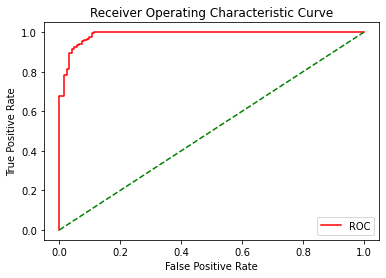

In [21]:
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, color='red', label='ROC')
plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.show()